In [1]:
import pm4py
import pandas as pd

In [3]:
path = 'data/augmented_dispatch_event_log.csv'
df = pd.read_csv(path)

In [5]:
df = df.rename(columns={'case_id': 'old_order'})
df = df.drop(columns=['shiftname.1'])

In [7]:
from typing import List, Dict
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from collections import Counter
from typing import Tuple
from pm4py.objects.log.obj import EventLog, Trace

class PandasError(Exception):
  def __init__(self, message):
    print(f'Pandas Error |> {message}')
    super().__init__(message)

class ArgumentError(Exception):
  def __init__(self, message):
    print(f'Argument Error |> {message}')
    super().__init__(message)

class ValidationError(Exception):
  def __init__(self, message):
    print(f'Validation Error |> {message}')
    super().__init__(message)

def trimmed_mean(df: pd.DataFrame, col: str, trim_value: float = 0.05, only_upper: bool = True) -> pd.DataFrame:
  if col not in df.columns:
    raise PandasError(f'The column "{col}" is not in the dataframe columns')
  if trim_value >= 0.5:
    raise ArgumentError(f'The arg trim_value cannot be greater than 0.5')
  low_quantile = 0 if only_upper else trim_value
  return df[(df[col] > df[col].quantile(low_quantile)) & (df[col] < df[col].quantile(1 - trim_value))]

def analyze_column(df: pd.DataFrame, column_name: str) -> pd.Series | None:
  if column_name not in df.columns:
    print(f"'{column_name}' is not in the Dataframe")
    return None
  return df.groupby(column_name)[column_name].count().sort_values(ascending=False)

def filter_df_log_by_attribute(df_event_log: pd.DataFrame, col_attribute: str, col_value: str, negative: bool = False) -> pd.DataFrame:
  if col_attribute not in df_event_log.columns:
    raise ValidationError(f'"{col_attribute}" is not in the dataframe columns {df_event_log.columns}')

  unique_values = df_event_log[col_attribute].unique()
  if col_value not in unique_values:
    raise ValidationError(f'"{col_value}" is not in the values of the column of {col_attribute}, values can be: {", ".join(unique_values.tolist())}')

  if negative:
    return df_event_log[df_event_log[col_attribute] != col_value]

  return df_event_log[df_event_log[col_attribute] == col_value]

def filter_activities(df: pd.DataFrame, activities: List[str], remove: bool = False) -> pd.DataFrame:
  all_activities = df['activity'].unique().tolist()
  if len(set(activities) - set(all_activities)) > 0:
    raise ValidationError(f'There are activities to filter that does not appears in the dataframe {", ".join(list(set(activities) - set(all_activities)))}')

  if remove:
    return df[~df['activity'].isin(activities)]

  return df[df['activity'].isin(activities)]

def process_event_log(event_log: EventLog) -> Tuple[Counter, Counter]:
  performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(event_log)
  pm4py.view_performance_dfg(performance_dfg, start_activities, end_activities)

  # See the time taken between activities
  dfg_frequency = dfg_discovery.apply(event_log)
  gviz = dfg_visualization.apply(dfg_frequency, log=event_log, variant=dfg_visualization.Variants.FREQUENCY)
  dfg_visualization.view(gviz)
  return (performance_dfg, dfg_frequency)

def initial_dataframe_analysis(df: pd.DataFrame, with_dfg: bool = False) -> Tuple[EventLog, Counter | None, Counter | None]:
  df_formed = pm4py.format_dataframe(df, case_id='case_id', activity_key='activity', timestamp_key='timestamp')
  event_log = pm4py.convert_to_event_log(df_formed)
  # See the traces repetitions
  performance_dfg, dfg_frequency = None, None
  if with_dfg:
    performance_dfg, dfg_frequency = process_event_log(event_log)

  return (event_log, performance_dfg, dfg_frequency)

def check_variant_frequency(variants: Dict[Tuple[str], List[Trace]]) -> pd.DataFrame:
  variants_items = variants.items()
  variants_items_frequency = [[', '.join(variant_str), len(trace)] for variant_str, trace in variants_items]
  df_traces = pd.DataFrame(variants_items_frequency, columns=['variant', 'frequency']).sort_values(by='frequency', ascending=False)
  df_traces['total_percent'] = (df_traces['frequency'] / df_traces['frequency'].sum() * 100).round(4)
  return df_traces

In [8]:
def generate_df_case_id(df: pd.DataFrame, case_id_columns=list, additional_columns=list) -> pd.DataFrame:
  FIXED_COLUMNS = ['case_id', 'activity', 'timestamp']
  MINIMUM_COLUMNS = ['activity', 'timestamp']
  if len(set(MINIMUM_COLUMNS) - set(df.columns)):
    needed_columns = [*(set(MINIMUM_COLUMNS) - set(df.columns))]
    raise ValidationError(f'Dataframe should contains items: "{", ".join(needed_columns)}"')
  df_initial = df.copy()
  temporal_case_id_key = 'id_proposed'
  df_initial[temporal_case_id_key] = df_initial[case_id_columns[0]].str.cat(df_initial[case_id_columns[1]], sep='-')
  df_initial['case_id'] = df_initial.groupby(by=temporal_case_id_key).ngroup() + 1
  df_joined = df_initial.sort_values(by='case_id')
  df_joined = df_joined[[*FIXED_COLUMNS, *case_id_columns, *additional_columns]]
  return df_joined

In [12]:
proposed_case_id_keys = ['truck', 'shiftname']
additional_columns = ['crew', 'loadlocation', 'loadlocationunit', 'old_order']
df_proposed = generate_df_case_id(df, proposed_case_id_keys, additional_columns)
df_proposed = filter_activities(df_proposed, ['Spotting Carga', 'FullTime Carga', 'Loading Carga', 'Dumping Descarga'], remove=True)
df_proposed.sort_values(by=['case_id', 'timestamp', 'old_order']);

In [13]:
df_proposed.head()

,case_id,activity,timestamp,truck,shiftname,crew,loadlocation,loadlocationunit,old_order
308192,1,Assign Descarga,2024-02-26 01:55:26+00:00,CA100,240226a,G4,F9,Disparo,43030
308193,1,Arrive Descarga,2024-02-26 01:58:42+00:00,CA100,240226a,G4,F9,Disparo,43030
308195,1,Empty Descarga,2024-02-26 02:01:12+00:00,CA100,240226a,G4,F9,Disparo,43030
304110,1,Assign Carga,2024-02-26 07:46:01+00:00,CA100,240226a,G4,STOC,Stock,42618
304111,1,Arrive Carga,2024-02-26 07:49:58+00:00,CA100,240226a,G4,STOC,Stock,42618


In [14]:
event_log, _, _ = initial_dataframe_analysis(df_proposed);
variants = pm4py.get_variants(event_log)
print(len(event_log))
len(variants)

2909


2621

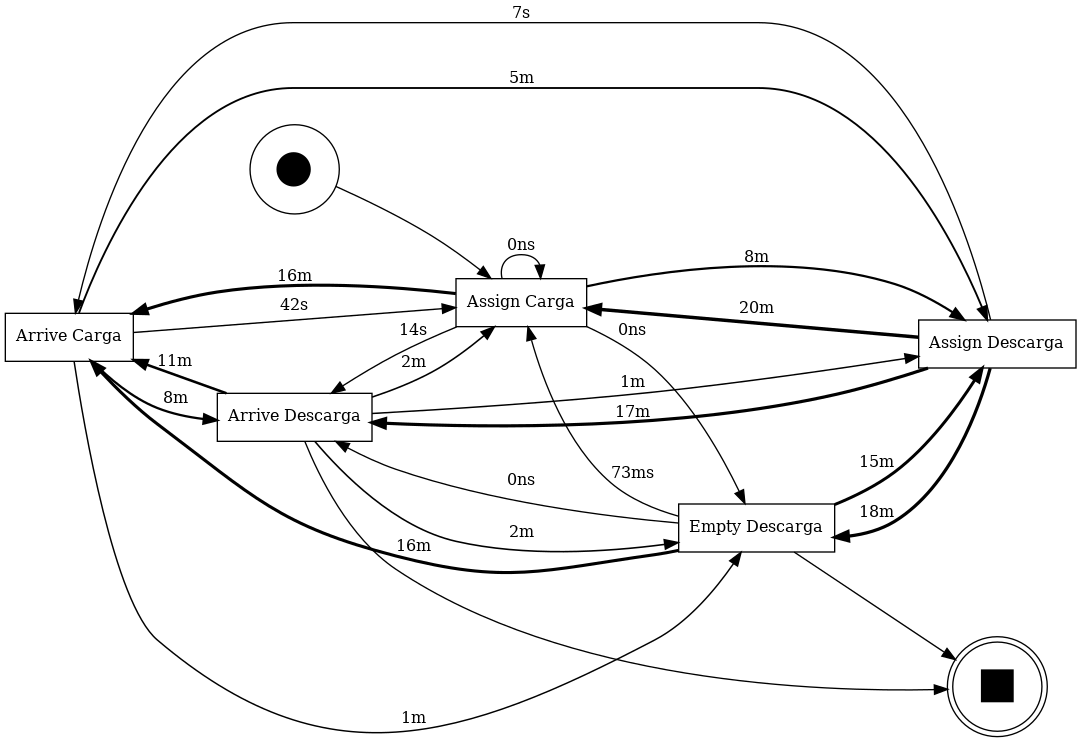

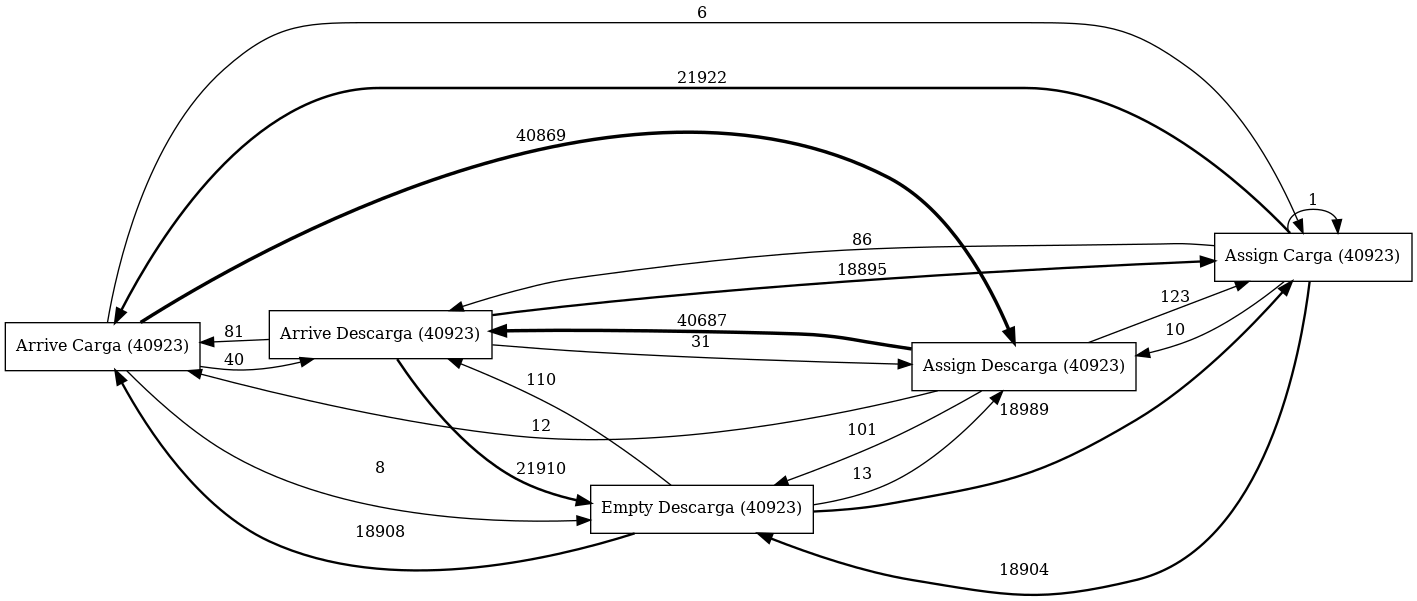

In [18]:
event_log_activities_filtered, performance_counter, frecuency_counter = initial_dataframe_analysis(df_proposed, with_dfg=True)

In [26]:
dict_counter = dict(frecuency_counter)

In [42]:
threshold_frecuency = 200
filtered_activities_freq = dict([[arc, freq] for arc, freq in dict_counter.items() if freq > 200])
filtered_dfg = Counter(filtered_activities_freq)

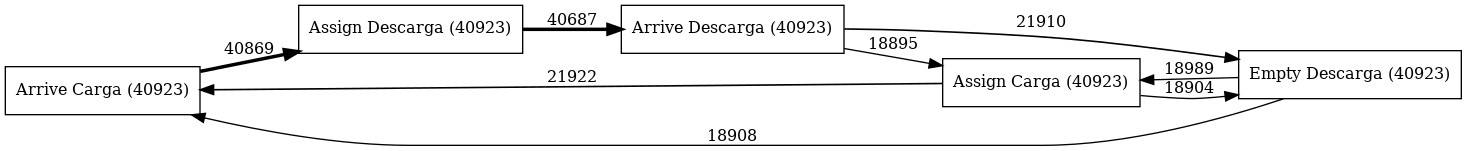

In [37]:
gviz = dfg_visualization.apply(filtered_dfg, log=event_log_activities_filtered, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

- El flujo normal debería ser `Arrive Carga` -> `Assign Descarga` -> `Arrive Descarga` -> `Empty Descarga` -> `Assign Descarga` y repite ciclo
- Parece ocurrir de manera normal `Arrive Carga` -> `Assign Descarga` -> `Arrive descarga`
- En aproximadamente la mitad de los casos se `Assign Carga` antes que `Empty Descarga`

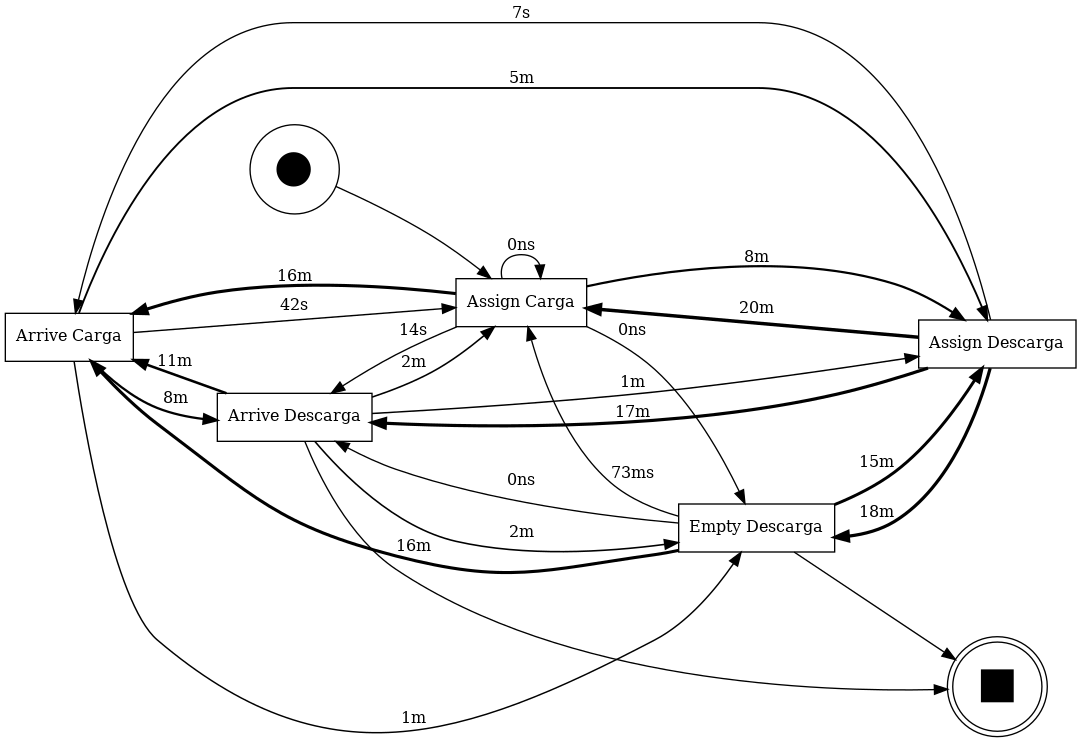

In [38]:
performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(event_log)
pm4py.view_performance_dfg(performance_dfg, start_activities, end_activities)

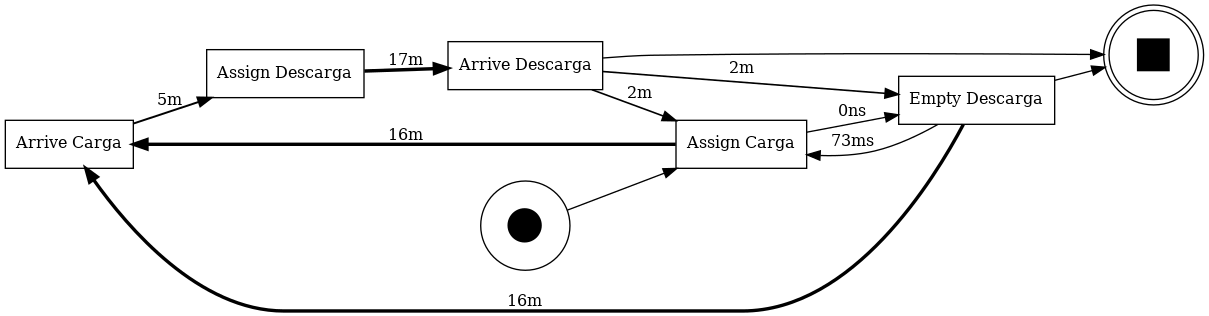

In [49]:
filtered_arcs = filtered_activities_freq.keys()
filtered_performance = { arc: metrics for arc, metrics in performance_dfg.items() if arc in filtered_arcs }
performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(event_log)
pm4py.view_performance_dfg(filtered_performance, start_activities, end_activities)

- Entre `Assign Carga` y `Arrive Descarga` existe un cuello de botella, en la "vuelta" del camion
- Entre `Assign Carga` y `Arrive Carga` existe un cuello de botella
- Entre `Empty Descarga` y `Arrive Carga` existe un cuello de botella
- Sin embargo entre `Assign carga` y `Empty Descarga` el tiempo es minúsculo por lo que debe ser un error de precisión cuando se registra el Event Log y para efectos de Event Log conviene pensar o asumir que se realiza con el orden `Empty Descarga` - `Assign Carga`. Esto dado que la asignación de la descarga debe ser automático para cada camión